# ЛР3. Разработка свёрточной сети

In [2]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/'My Drive'/datasets/gtsrb-german-traffic-sign.zip .

import zipfile
with zipfile.ZipFile('gtsrb-german-traffic-sign.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

!ls

gdrive			       meta  Meta.csv	  test	Test.csv  Train
gtsrb-german-traffic-sign.zip  Meta  sample_data  Test	train	  Train.csv


In [4]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
import csv
from time import time
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 2.x selected.


### Описание датасета

Рассматривается задача классификации [немецких дорожных знаков](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) *GTSRB - German Traffic Sign Recognition Benchmark*.

* Train, train.csv - размеченные данные
* Test, Test.scv - тестовые данные
* Meta, Meta.csv - дополнительные данные

Для экспериментах задействованы обучающие и тестовые данные. 
Обучающая выборка содержит 43 класса.

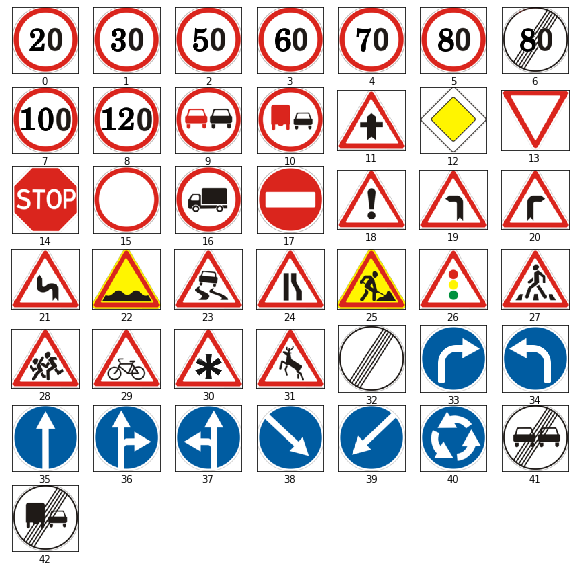

In [21]:
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = "meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

### Загружаем данные

In [0]:
# Предообработка данных
def preprocess(image, out_side):
	height, width = image.shape[:2]
	scale = out_side / max(height, width)
	dx = (out_side - scale * width) / 2
	dy = (out_side - scale * height) / 2
	trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
	image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
	return image

# Перемешивание данных
def mixing(images, labels):
		images = np.array(images)
		labels = np.array(labels)
		s = np.arange(images.shape[0])
		np.random.seed(43)
		np.random.shuffle(s)
		images=images[s]
		labels=labels[s]
		return images, labels

# Загрузка тренировочных данных
def load_train(path, out_side):
	images = []
	labels = []
	for folder in os.listdir(os.path.join(path, 'Train')):
		cur_path = os.path.join(path, 'Train', folder)
		for file_name in os.listdir(cur_path):
			image = cv2.imread(os.path.join(cur_path, file_name))
			images.append(preprocess(image, out_side))
			labels.append(int(folder))
	
	return mixing(images, labels)

# Загрузка тестовых данных
def load_test(path, out_side):
	images = []
	labels = []
	with open(os.path.join(path, 'Test.csv'), 'r') as f:
		reader = csv.reader(f)
		for rows in reader:
			name = rows[7]
			if (name == 'Path'):
				continue
			image = cv2.imread(os.path.join(path, rows[7]))
			images.append(preprocess(image, out_side))
			labels.append(int(rows[6]))
	
	return mixing(images, labels)

In [6]:
start = time()

# Загружаем предобработанные изображения в разрешении 50x50
train_images, train_labels = load_train(".", 50)
test_images, test_labels = load_test(".", 50)
shape = train_images[0].shape
print(shape)

# Нормализуем данные
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# Преобразуем метки в one-hot-encoding
train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  10.530662298202515


### Запускаем сеть

In [0]:
classes = 43 # Количество классов изображений
batch = 256 # Размер мини-выборки
epochs = 15 # Количество эпох для обучения
learning_rate = 0.001 # Коэффициент скорости обучения

def results(model):
  adam = Adam(lr=learning_rate)

  # Компилируем модель
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  # Обучаем модель
  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, verbose=1)
  train_time = time() - start

  # Архитектура сети
  model.summary()

  # Графики изменения метрик
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  # Запускаем на тестовых данных
  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

#### Конфигурация №1

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 3s 85us/sample - loss: 2.6664 - accuracy: 0.3325 - val_loss: 1.7711 - val_accuracy: 0.5555
Epoch 2/15
31199/31199 [==============================] - 2s 69us/sample - loss: 1.2809 - accuracy: 0.6858 - val_loss: 0.8972 - val_accuracy: 0.8013
Epoch 3/15
31199/31199 [==============================] - 2s 68us/sample - loss: 0.6357 - accuracy: 0.8742 - val_loss: 0.4992 - val_accuracy: 0.9010
Epoch 4/15
31199/31199 [==============================] - 2s 68us/sample - loss: 0.3489 - accuracy: 0.9424 - val_loss: 0.2979 - val_accuracy: 0.9449
Epoch 5/15
31199/31199 [==============================] - 2s 64us/sample - loss: 0.2117 - accuracy: 0.9698 - val_loss: 0.2108 - val_accuracy: 0.9647
Epoch 6/15
31199/31199 [==============================] - 2s 65us/sample - loss: 0.1391 - accuracy: 0.9819 - val_loss: 0.1526 - val_accuracy: 0.9745
Epoch 7/15
31199/31199 [==============================] -

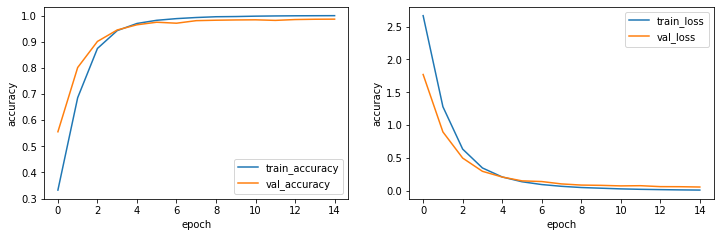

12630/12630 [==============================] - 1s 95us/sample - loss: 0.3625 - accuracy: 0.9127

Train time:  31.85645842552185
Test accuracy: 0.9126682
Test loss: 0.3625334594566862
Test time:  1.4599392414093018


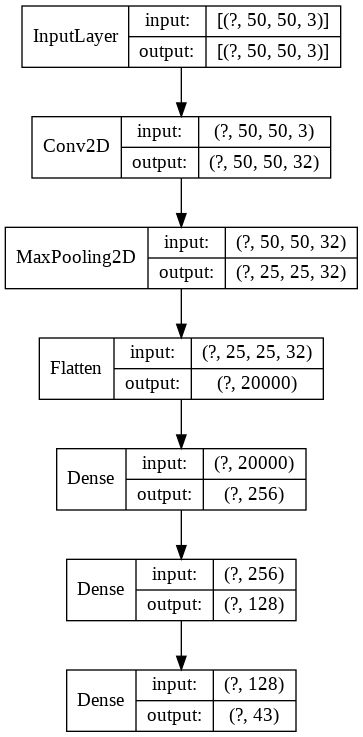

In [25]:
# Создаём модель
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №2

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 2s 80us/sample - loss: 2.7727 - accuracy: 0.2962 - val_loss: 1.8177 - val_accuracy: 0.5376
Epoch 2/15
31199/31199 [==============================] - 2s 67us/sample - loss: 1.2734 - accuracy: 0.6910 - val_loss: 0.8692 - val_accuracy: 0.8047
Epoch 3/15
31199/31199 [==============================] - 2s 66us/sample - loss: 0.6018 - accuracy: 0.8844 - val_loss: 0.4554 - val_accuracy: 0.9167
Epoch 4/15
31199/31199 [==============================] - 2s 66us/sample - loss: 0.3358 - accuracy: 0.9469 - val_loss: 0.2941 - val_accuracy: 0.9477
Epoch 5/15
31199/31199 [==============================] - 2s 66us/sample - loss: 0.2093 - accuracy: 0.9707 - val_loss: 0.2180 - val_accuracy: 0.9595
Epoch 6/15
31199/31199 [==============================] - 2s 66us/sample - loss: 0.1444 - accuracy: 0.9803 - val_loss: 0.1716 - val_accuracy: 0.9667
Epoch 7/15
31199/31199 [==============================] -

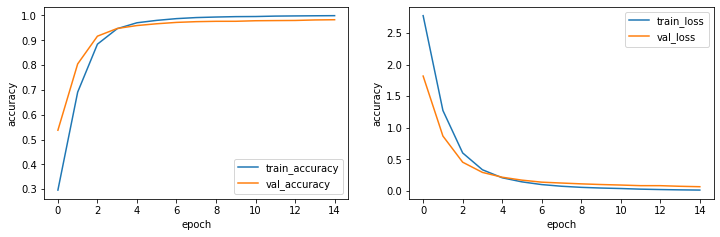

12630/12630 [==============================] - 1s 96us/sample - loss: 0.3973 - accuracy: 0.9059

Train time:  31.454670906066895
Test accuracy: 0.90585905
Test loss: 0.3973038922815406
Test time:  1.2446322441101074


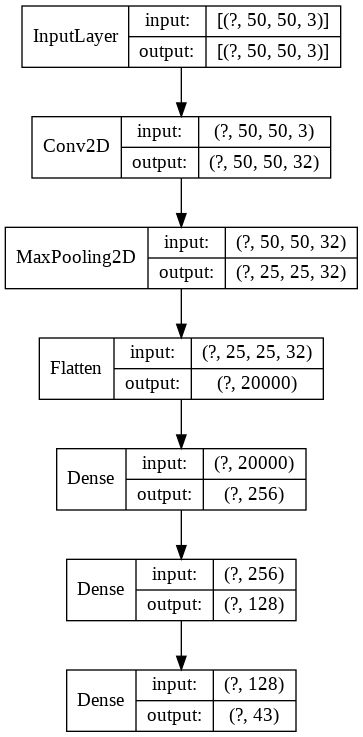

In [26]:
# Создаём модель
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(50, 50, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №3

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 6s 197us/sample - loss: 2.6420 - accuracy: 0.3391 - val_loss: 1.6815 - val_accuracy: 0.5919
Epoch 2/15
31199/31199 [==============================] - 6s 181us/sample - loss: 1.1202 - accuracy: 0.7428 - val_loss: 0.7061 - val_accuracy: 0.8550
Epoch 3/15
31199/31199 [==============================] - 6s 183us/sample - loss: 0.4633 - accuracy: 0.9236 - val_loss: 0.3364 - val_accuracy: 0.9529
Epoch 4/15
31199/31199 [==============================] - 6s 185us/sample - loss: 0.2174 - accuracy: 0.9751 - val_loss: 0.1865 - val_accuracy: 0.9737
Epoch 5/15
31199/31199 [==============================] - 6s 186us/sample - loss: 0.1210 - accuracy: 0.9874 - val_loss: 0.1358 - val_accuracy: 0.9779
Epoch 6/15
31199/31199 [==============================] - 6s 186us/sample - loss: 0.0762 - accuracy: 0.9927 - val_loss: 0.1099 - val_accuracy: 0.9792
Epoch 7/15
31199/31199 [===========================

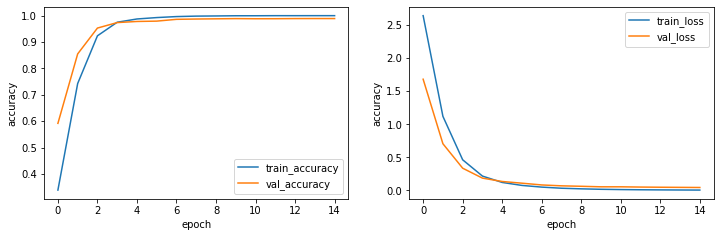

12630/12630 [==============================] - 2s 139us/sample - loss: 0.3250 - accuracy: 0.9218

Train time:  86.73788452148438
Test accuracy: 0.92177355
Test loss: 0.32500627360359036
Test time:  1.7834992408752441


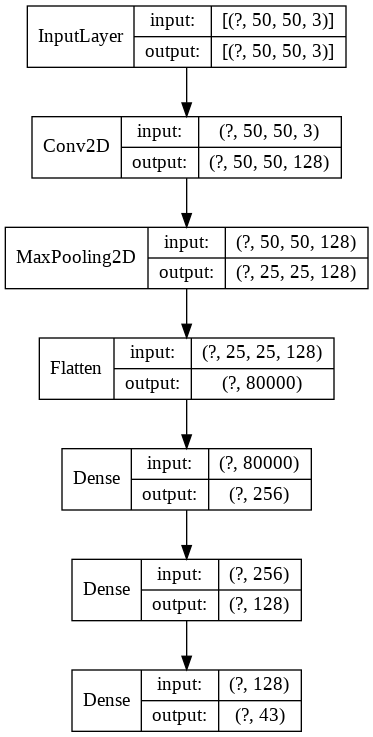

In [27]:
# Создаём модель
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №4

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 6s 199us/sample - loss: 2.4593 - accuracy: 0.3981 - val_loss: 1.5097 - val_accuracy: 0.6373
Epoch 2/15
31199/31199 [==============================] - 6s 187us/sample - loss: 1.0052 - accuracy: 0.7748 - val_loss: 0.6587 - val_accuracy: 0.8695
Epoch 3/15
31199/31199 [==============================] - 6s 187us/sample - loss: 0.4624 - accuracy: 0.9208 - val_loss: 0.3764 - val_accuracy: 0.9303
Epoch 4/15
31199/31199 [==============================] - 6s 186us/sample - loss: 0.2461 - accuracy: 0.9671 - val_loss: 0.2379 - val_accuracy: 0.9600
Epoch 5/15
31199/31199 [==============================] - 6s 187us/sample - loss: 0.1491 - accuracy: 0.9825 - val_loss: 0.1776 - val_accuracy: 0.9672
Epoch 6/15
31199/31199 [==============================] - 6s 188us/sample - loss: 0.0978 - accuracy: 0.9894 - val_loss: 0.1341 - val_accuracy: 0.9745
Epoch 7/15
31199/31199 [===========================

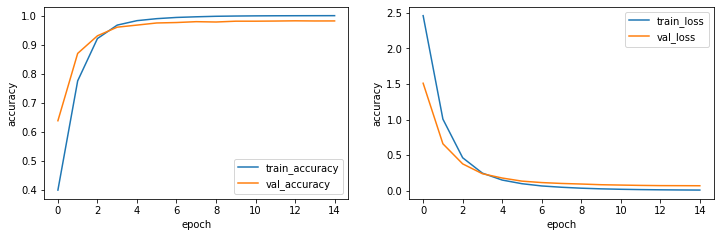

12630/12630 [==============================] - 2s 141us/sample - loss: 0.3734 - accuracy: 0.9083

Train time:  87.79393291473389
Test accuracy: 0.9083135
Test loss: 0.37338244738507065
Test time:  1.8207411766052246


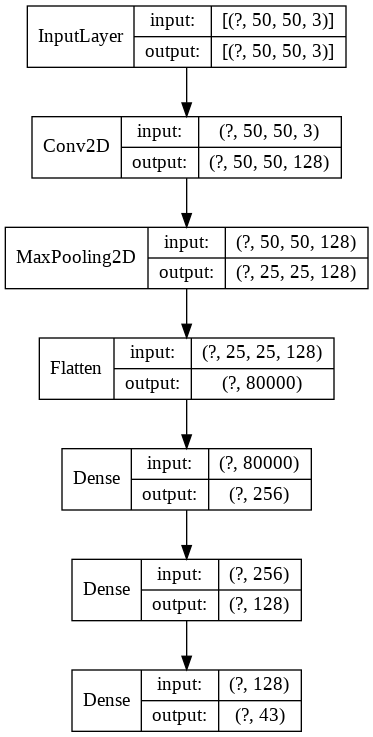

In [28]:
# Создаём модель
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(50, 50, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №5

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 3s 102us/sample - loss: 2.7280 - accuracy: 0.2967 - val_loss: 1.7360 - val_accuracy: 0.5382
Epoch 2/15
31199/31199 [==============================] - 3s 81us/sample - loss: 1.1846 - accuracy: 0.7135 - val_loss: 0.7531 - val_accuracy: 0.8555
Epoch 3/15
31199/31199 [==============================] - 3s 80us/sample - loss: 0.4995 - accuracy: 0.9156 - val_loss: 0.3650 - val_accuracy: 0.9295
Epoch 4/15
31199/31199 [==============================] - 2s 79us/sample - loss: 0.2485 - accuracy: 0.9656 - val_loss: 0.2242 - val_accuracy: 0.9664
Epoch 5/15
31199/31199 [==============================] - 2s 79us/sample - loss: 0.1483 - accuracy: 0.9830 - val_loss: 0.1481 - val_accuracy: 0.9781
Epoch 6/15
31199/31199 [==============================] - 2s 79us/sample - loss: 0.0934 - accuracy: 0.9909 - val_loss: 0.1037 - val_accuracy: 0.9849
Epoch 7/15
31199/31199 [==============================] 

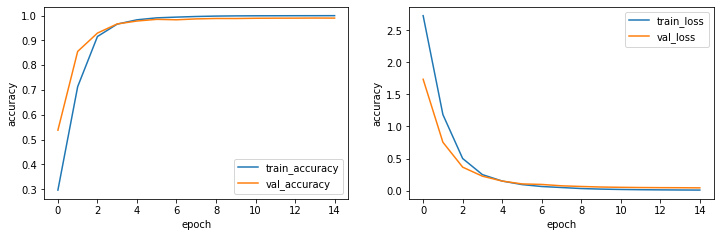

12630/12630 [==============================] - 1s 111us/sample - loss: 0.3034 - accuracy: 0.9243

Train time:  38.108118772506714
Test accuracy: 0.9243072
Test loss: 0.3034343985768414
Test time:  1.4384119510650635


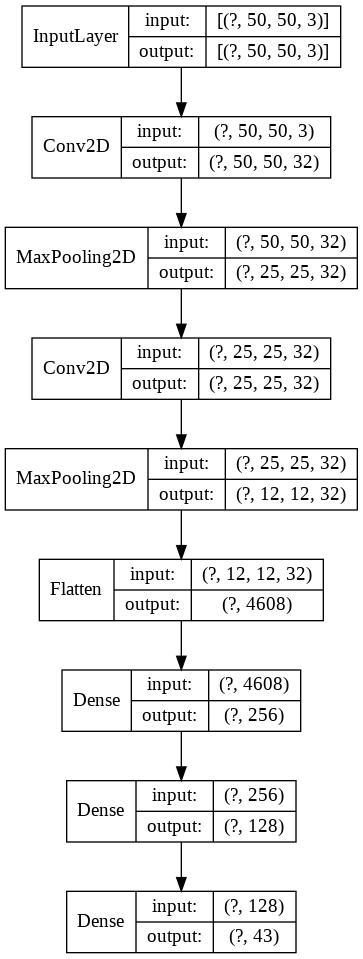

In [29]:
# Создаём модель
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №6

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 3s 98us/sample - loss: 2.6978 - accuracy: 0.2936 - val_loss: 1.7763 - val_accuracy: 0.4991
Epoch 2/15
31199/31199 [==============================] - 2s 79us/sample - loss: 1.2722 - accuracy: 0.6685 - val_loss: 0.7916 - val_accuracy: 0.8391
Epoch 3/15
31199/31199 [==============================] - 2s 79us/sample - loss: 0.5069 - accuracy: 0.9127 - val_loss: 0.3499 - val_accuracy: 0.9381
Epoch 4/15
31199/31199 [==============================] - 2s 80us/sample - loss: 0.2323 - accuracy: 0.9721 - val_loss: 0.1930 - val_accuracy: 0.9753
Epoch 5/15
31199/31199 [==============================] - 2s 80us/sample - loss: 0.1273 - accuracy: 0.9882 - val_loss: 0.1298 - val_accuracy: 0.9812
Epoch 6/15
31199/31199 [==============================] - 3s 80us/sample - loss: 0.0770 - accuracy: 0.9935 - val_loss: 0.0935 - val_accuracy: 0.9859
Epoch 7/15
31199/31199 [==============================] -

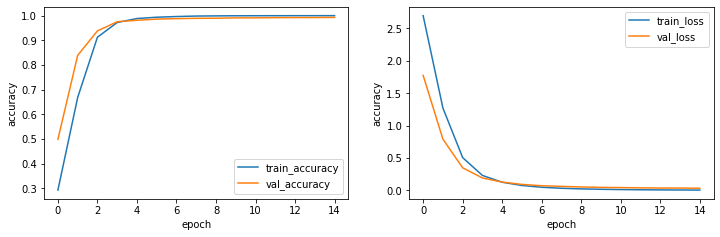

12630/12630 [==============================] - 1s 92us/sample - loss: 0.2644 - accuracy: 0.9360

Train time:  37.208696365356445
Test accuracy: 0.9360253
Test loss: 0.2644376587461878
Test time:  1.1927392482757568


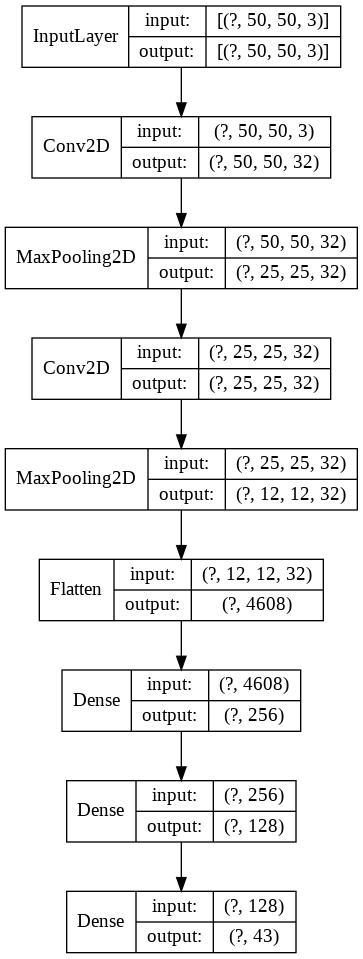

In [30]:
# Создаём модель
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(50, 50, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №7

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 8s 251us/sample - loss: 3.0450 - accuracy: 0.2214 - val_loss: 2.1218 - val_accuracy: 0.4713
Epoch 2/15
31199/31199 [==============================] - 7s 213us/sample - loss: 1.4438 - accuracy: 0.6422 - val_loss: 0.9582 - val_accuracy: 0.7692
Epoch 3/15
31199/31199 [==============================] - 7s 214us/sample - loss: 0.6720 - accuracy: 0.8558 - val_loss: 0.4786 - val_accuracy: 0.8969
Epoch 4/15
31199/31199 [==============================] - 7s 212us/sample - loss: 0.3430 - accuracy: 0.9369 - val_loss: 0.2708 - val_accuracy: 0.9472
Epoch 5/15
31199/31199 [==============================] - 7s 213us/sample - loss: 0.1904 - accuracy: 0.9743 - val_loss: 0.1722 - val_accuracy: 0.9692
Epoch 6/15
31199/31199 [==============================] - 7s 212us/sample - loss: 0.1148 - accuracy: 0.9884 - val_loss: 0.1200 - val_accuracy: 0.9796
Epoch 7/15
31199/31199 [===========================

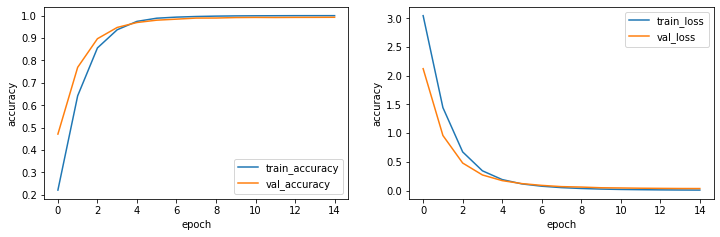

12630/12630 [==============================] - 2s 146us/sample - loss: 0.2815 - accuracy: 0.9302

Train time:  100.44398951530457
Test accuracy: 0.93024546
Test loss: 0.2814958083728713
Test time:  1.8781511783599854


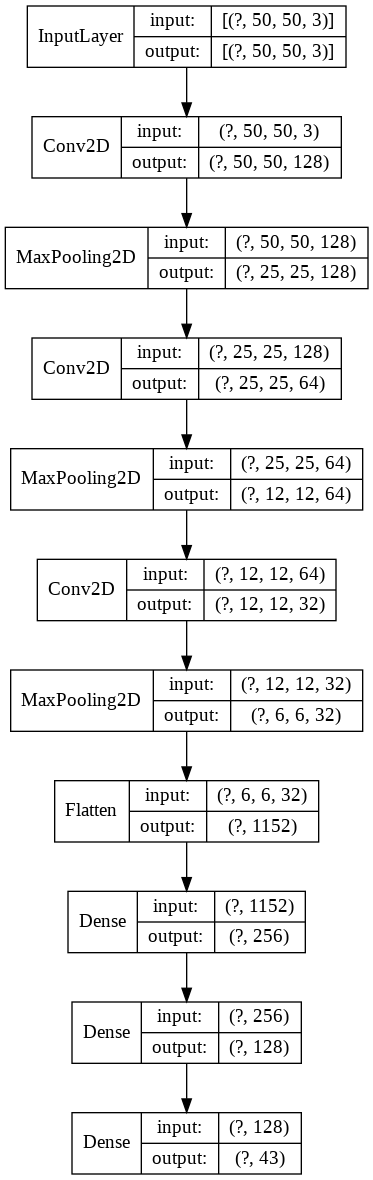

In [31]:
# Создаём модель
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №8

Train on 31199 samples, validate on 7800 samples
Epoch 1/15
31199/31199 [==============================] - 7s 230us/sample - loss: 2.6964 - accuracy: 0.2747 - val_loss: 1.8769 - val_accuracy: 0.4323
Epoch 2/15
31199/31199 [==============================] - 7s 213us/sample - loss: 1.4842 - accuracy: 0.5619 - val_loss: 1.1173 - val_accuracy: 0.6991
Epoch 3/15
31199/31199 [==============================] - 7s 212us/sample - loss: 0.7370 - accuracy: 0.8347 - val_loss: 0.4967 - val_accuracy: 0.9004
Epoch 4/15
31199/31199 [==============================] - 7s 213us/sample - loss: 0.3351 - accuracy: 0.9448 - val_loss: 0.2564 - val_accuracy: 0.9599
Epoch 5/15
31199/31199 [==============================] - 7s 212us/sample - loss: 0.1733 - accuracy: 0.9793 - val_loss: 0.1549 - val_accuracy: 0.9774
Epoch 6/15
31199/31199 [==============================] - 7s 212us/sample - loss: 0.0992 - accuracy: 0.9909 - val_loss: 0.1104 - val_accuracy: 0.9815
Epoch 7/15
31199/31199 [===========================

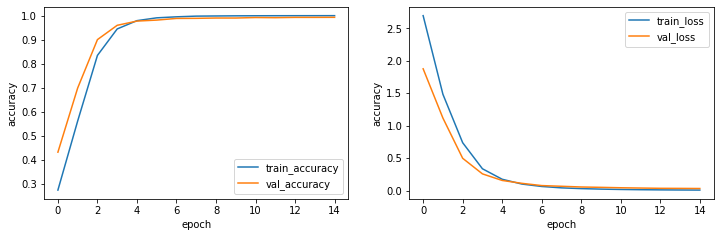

12630/12630 [==============================] - 2s 134us/sample - loss: 0.2600 - accuracy: 0.9382

Train time:  100.14224362373352
Test accuracy: 0.9381631
Test loss: 0.260018693065228
Test time:  1.7228200435638428


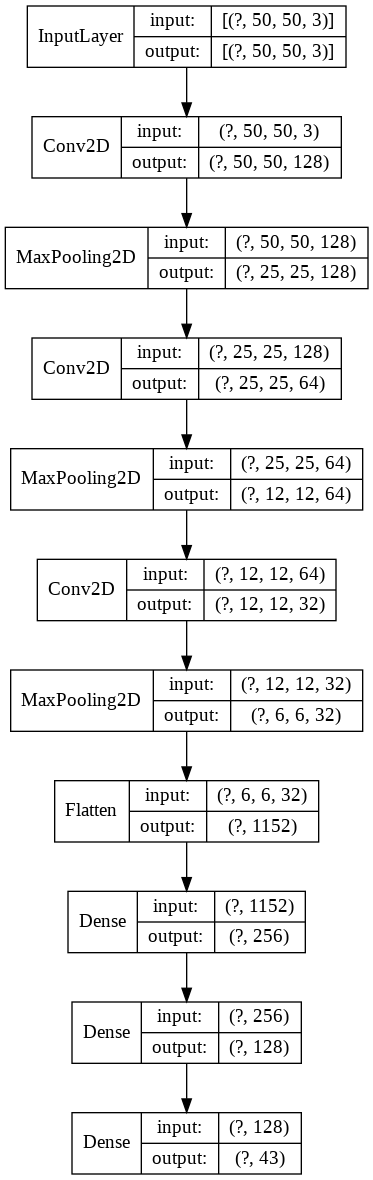

In [32]:
# Создаём модель
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(50, 50, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №9

Train on 31367 samples, validate on 7842 samples
Epoch 1/15
31367/31367 [==============================] - 23s 741us/sample - loss: 2.7389 - accuracy: 0.2976 - val_loss: 1.6591 - val_accuracy: 0.5765
Epoch 2/15
31367/31367 [==============================] - 13s 421us/sample - loss: 1.0225 - accuracy: 0.7642 - val_loss: 0.5562 - val_accuracy: 0.9017
Epoch 3/15
31367/31367 [==============================] - 13s 425us/sample - loss: 0.3479 - accuracy: 0.9488 - val_loss: 0.2321 - val_accuracy: 0.9745
Epoch 4/15
31367/31367 [==============================] - 13s 424us/sample - loss: 0.1418 - accuracy: 0.9907 - val_loss: 0.1162 - val_accuracy: 0.9875
Epoch 5/15
31367/31367 [==============================] - 13s 425us/sample - loss: 0.0703 - accuracy: 0.9969 - val_loss: 0.0703 - val_accuracy: 0.9922
Epoch 6/15
31367/31367 [==============================] - 13s 428us/sample - loss: 0.0406 - accuracy: 0.9986 - val_loss: 0.0520 - val_accuracy: 0.9948
Epoch 7/15
31367/31367 [=====================

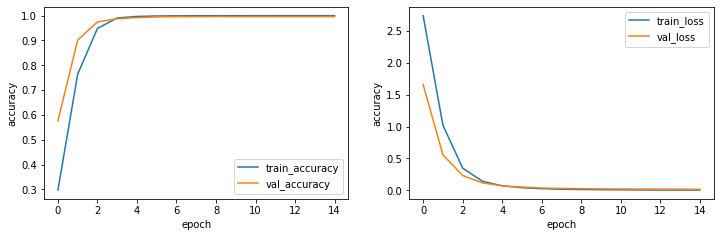

12630/12630 [==============================] - 3s 229us/sample - loss: 0.1707 - accuracy: 0.9560

Train time:  211.38968515396118
Test accuracy: 0.95597786
Test loss: 0.17065911516311238
Test time:  2.912487268447876


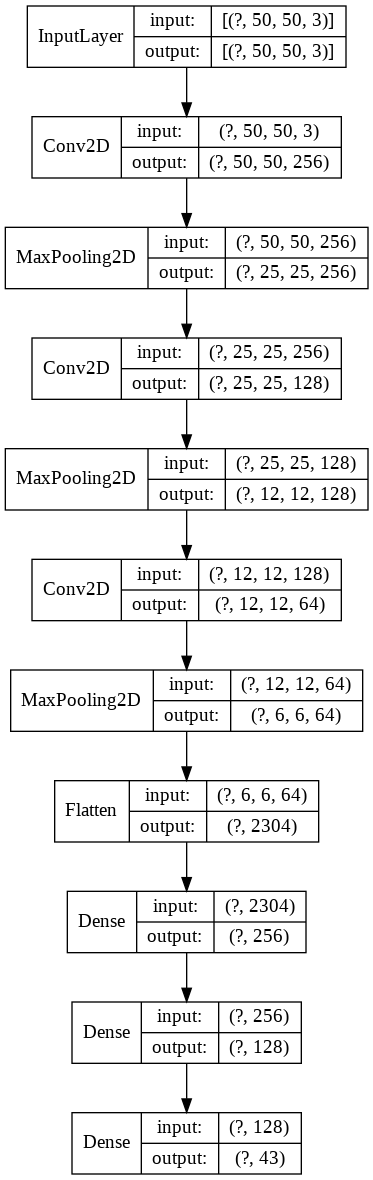

In [8]:
# Создаём модель
model = Sequential()
model.add(Conv2D(256, (3, 3), padding='same', input_shape=(50, 50, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)